In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from NCP.examples.tools.data_gen import gen_switching
from NCP.examples.tools.plot_utils import plot_expectation, setup_plots
from NCP.metrics import hellinger, kullback_leibler
from NCP.models.ncp import NCPModule, NCPOperator
from NCP.nn.callbacks import LitProgressBar
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.utils import from_np

setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Large region

### 1. split in the middle

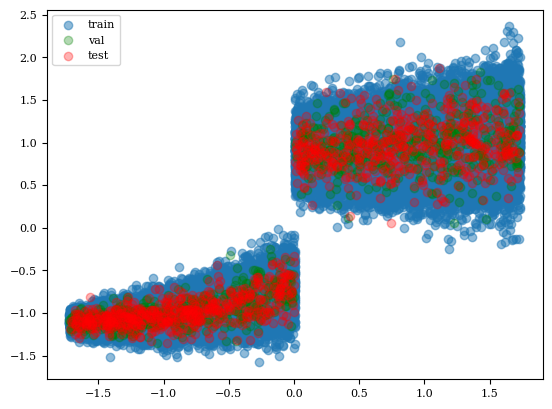

In [3]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_switching(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 36.1 K
--------------------------------------
36.1 K    Trainable params
0         Non-trainable params
36.1 K    Total params
0.144     Total estimated mod

d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 999: 100% 1/1 [00:00<00:00,  1.51it/s, v_num=1, val_loss=-1.63, train_loss=-1.62] `Trainer.fit` stopped: `max_epochs=1000` reached.
Epoch 999: 100% 1/1 [00:00<00:00,  1.48it/s, v_num=1, val_loss=-1.63, train_loss=-1.62]


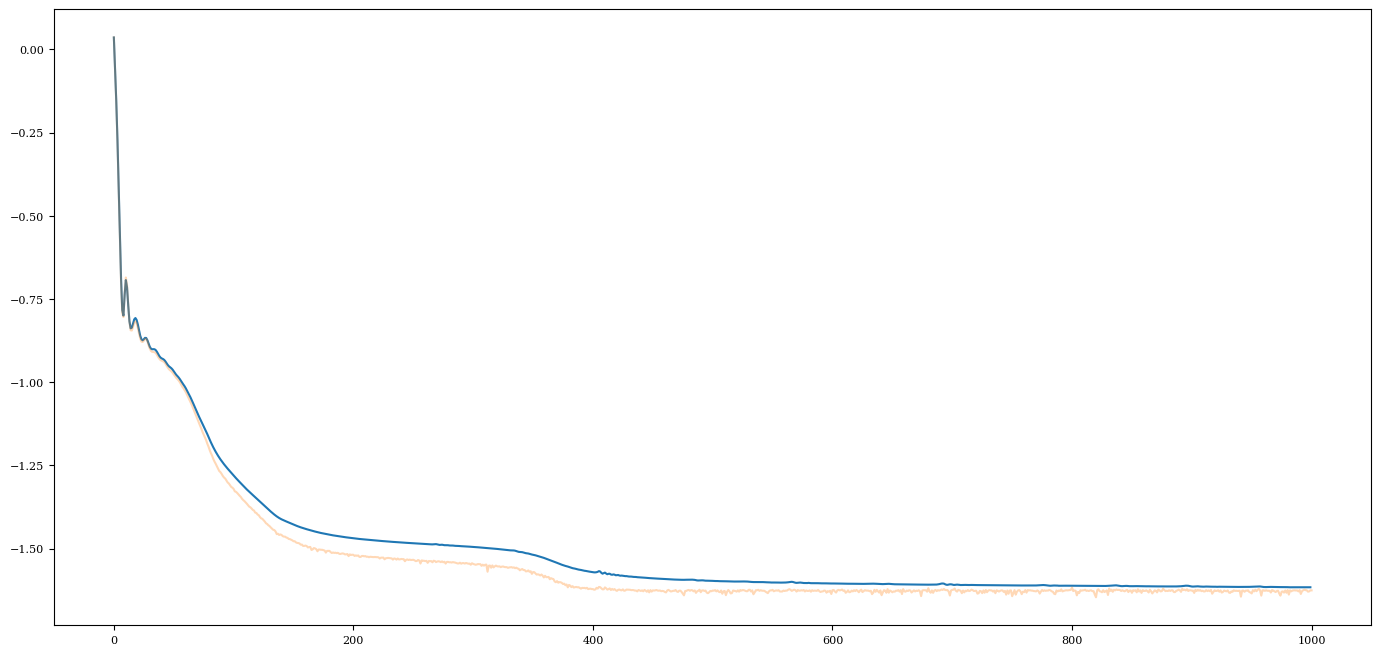

In [4]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = from_np(X_train)
Y_train_torch = from_np(Y_train)
X_val_torch = from_np(X_val)
Y_val_torch = from_np(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

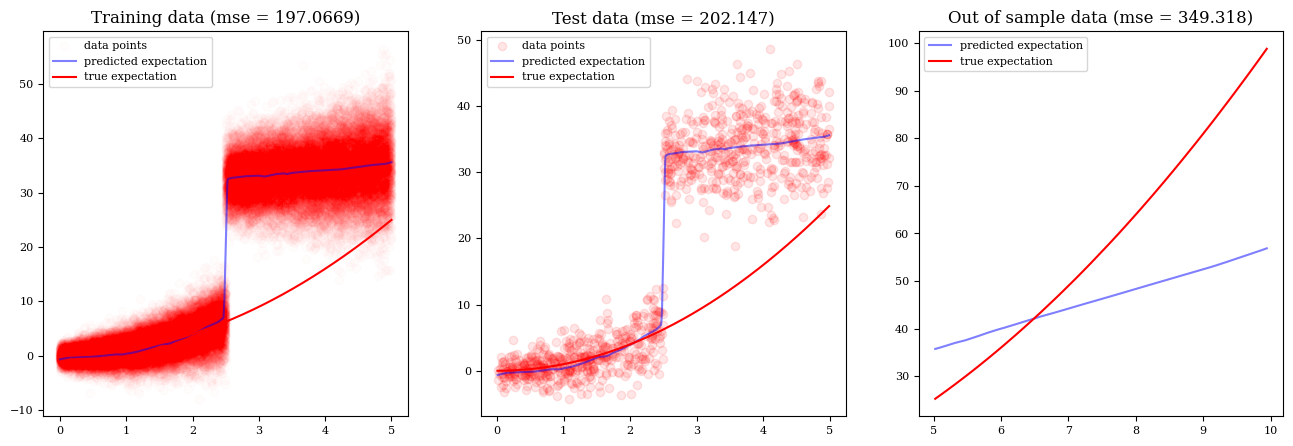

In [5]:
plot_expectation(reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = reg.cdf(x_scaled, Y_val, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    # normalising the plots for readability:
    if xi< 2.5:
        loc = xi**2
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    else:
        loc = xi + 30
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={round(xi, 3)}')
    print('result for x=', round(xi, 3))
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')

plt.show()

### 2. middle window

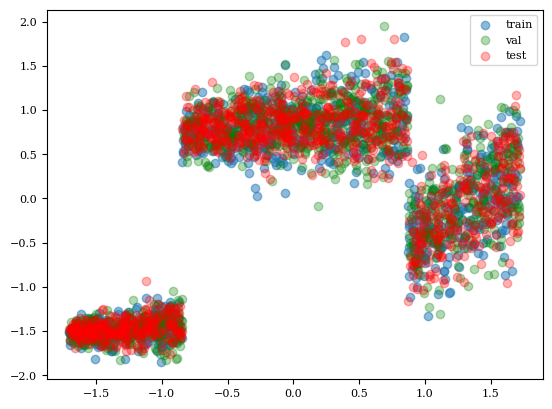

In [8]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_switching(0.5, 30, x_switch_min=1.25)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 9999, loss = -2.1707026958465576: 100%|██████████| 10000/10000 [01:29<00:00, 112.10it/s]


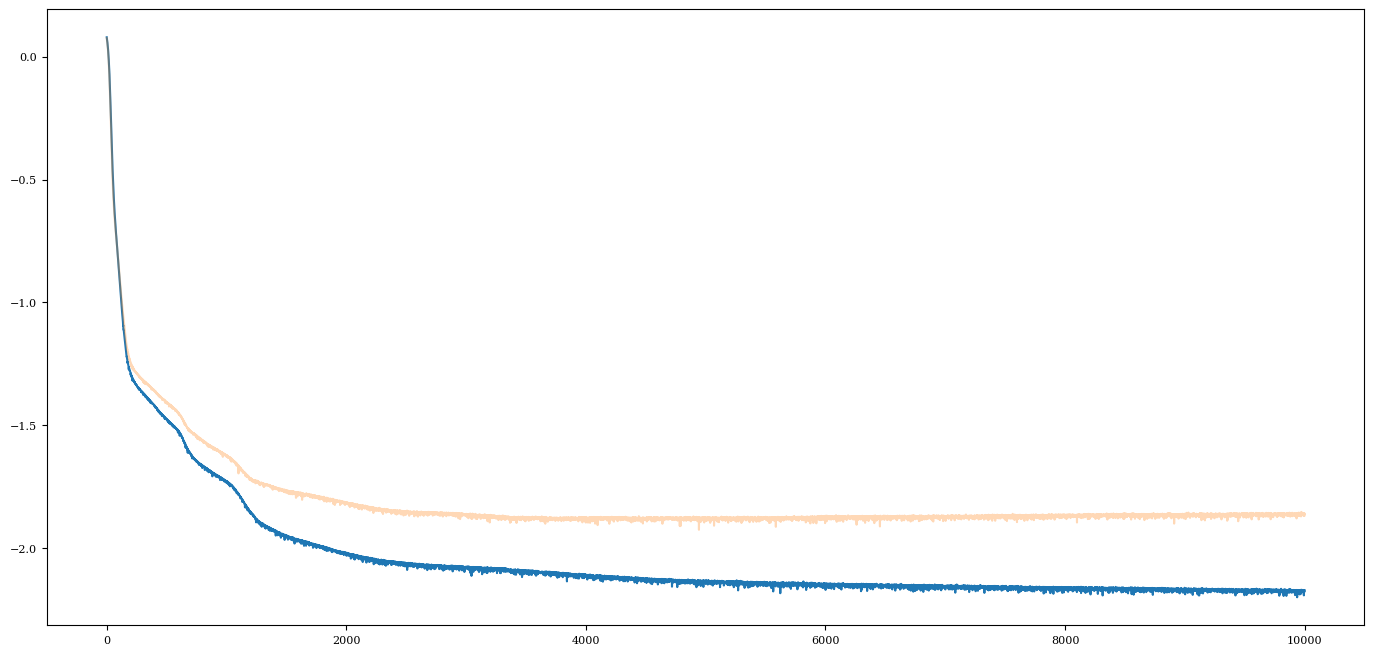

In [9]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = from_np(X_train)
Y_train_torch = from_np(Y_train)
X_val_torch = from_np(X_val)
Y_val_torch = from_np(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

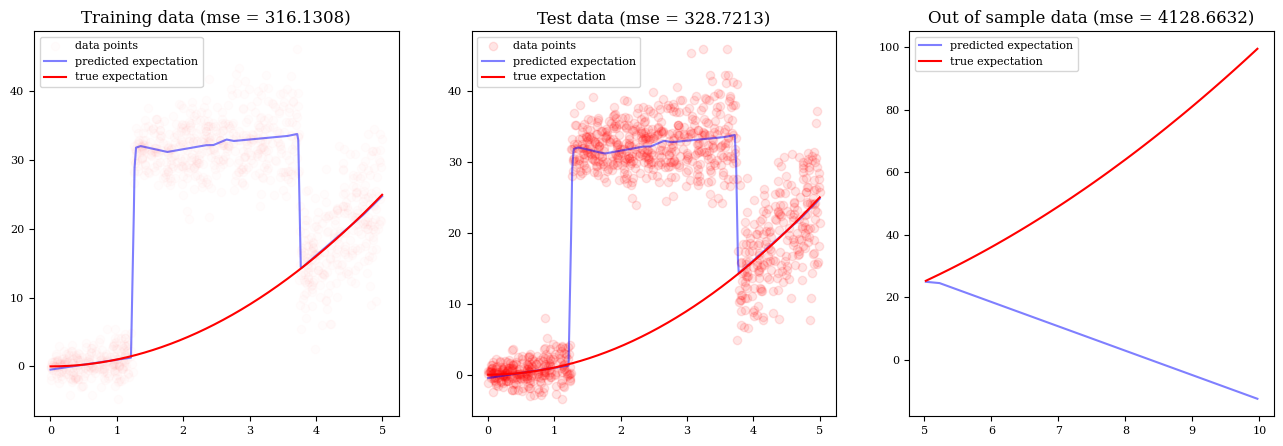

In [10]:
plot_expectation(reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: nan
- Hellinger: nan
result for x= 1
- KL: nan
- Hellinger: nan


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


result for x= 3
- KL: 0.714632731208318
- Hellinger: 0.2341519358725308
result for x= 4.5
- KL: 0.27355920669056855
- Hellinger: 0.18881575766946795


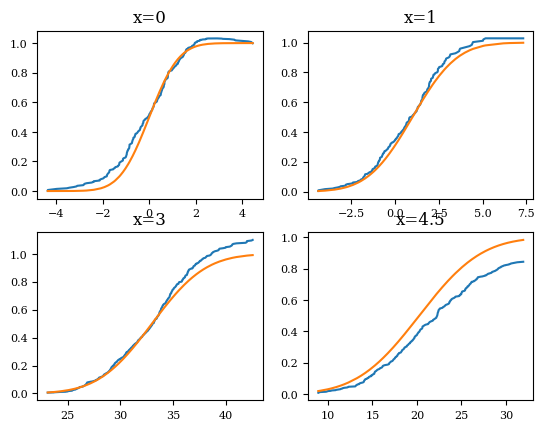

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = reg.cdf(reg, x_scaled, postprocess='whitening', Y=Y_val)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    # normalising the plots for readability:
    if xi< 1.25 or xi>3.75 :
        loc = xi**2
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    else:
        loc = xi + 30
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={round(xi, 3)}')
    print('result for x=', round(xi, 3))
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')

plt.show()

# Small region

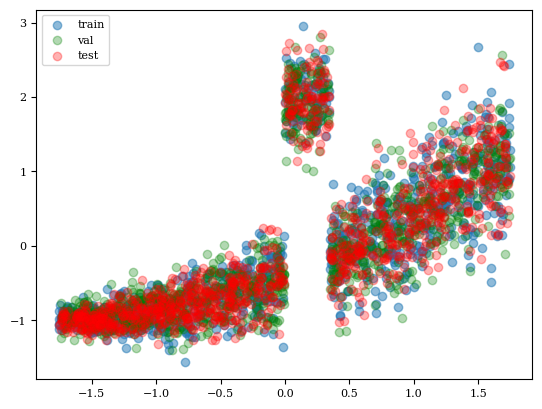

In [12]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_switching(0.1, 30)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 9999, loss = -2.3453094959259033: 100%|██████████| 10000/10000 [01:28<00:00, 112.69it/s]


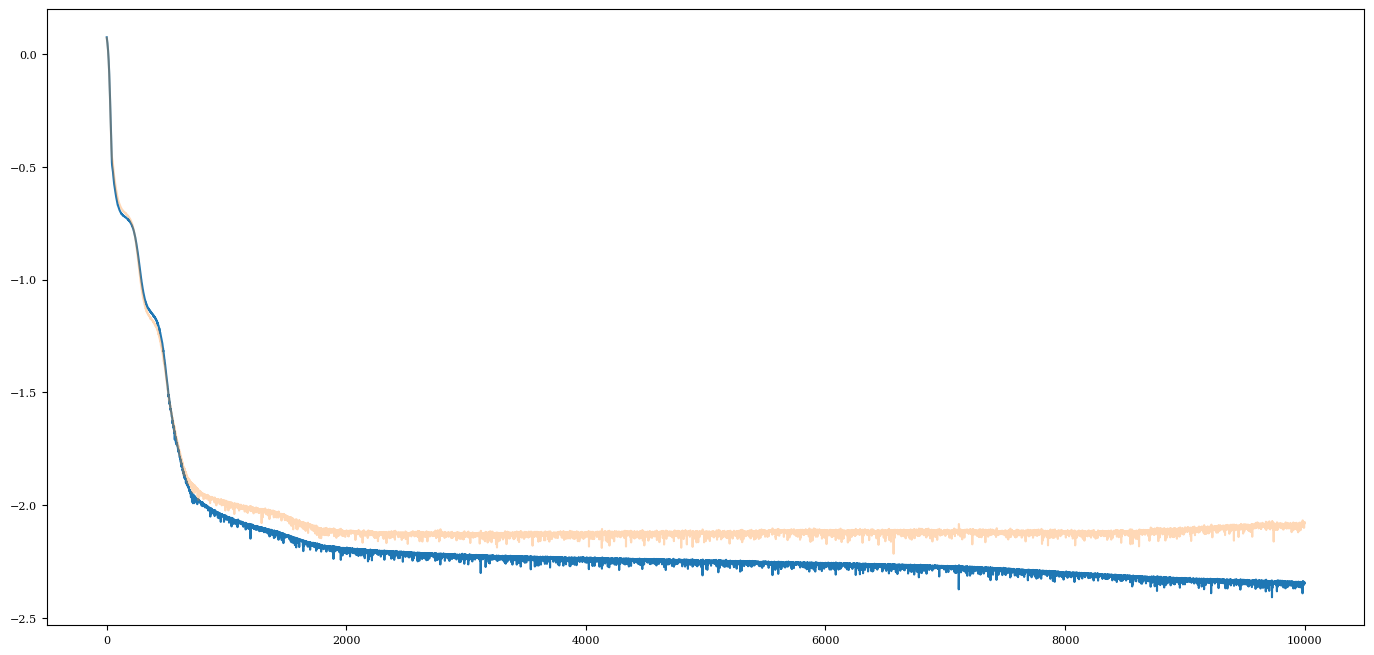

In [13]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = from_np(X_train)
Y_train_torch = from_np(Y_train)
X_val_torch = from_np(X_val)
Y_val_torch = from_np(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

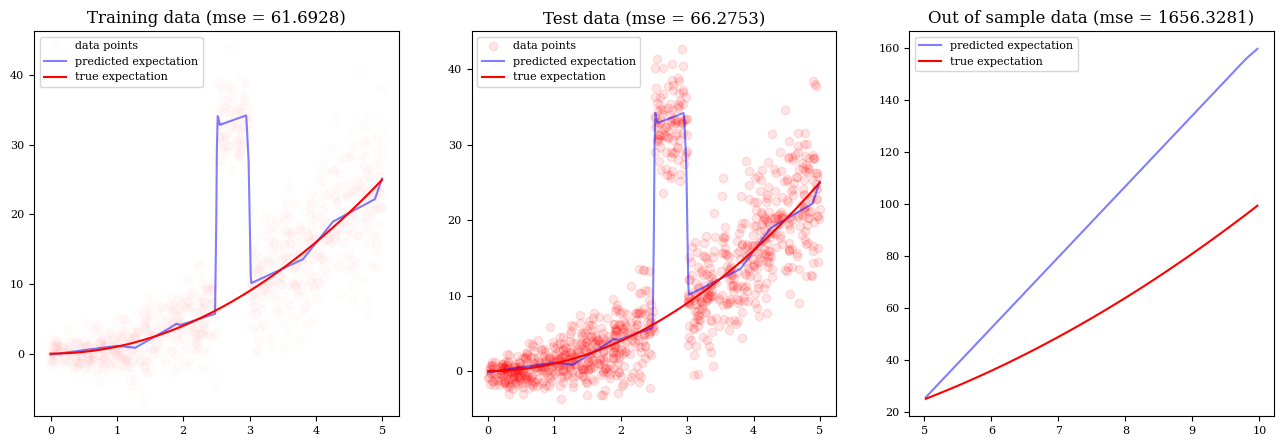

In [14]:
plot_expectation(reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: nan
- Hellinger: nan
result for x= 1
- KL: nan
- Hellinger: nan


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


result for x= 3.25
- KL: 0.4909919201066538
- Hellinger: 0.23729716820398558
result for x= 5
- KL: 0.6455297639625374
- Hellinger: 0.2571564909244617


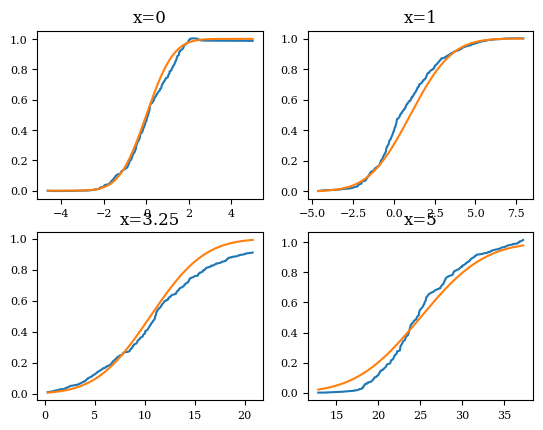

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3.25, 5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = reg.cdf(reg, x_scaled, postprocess='whitening', Y=Y_val)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    # normalising the plots for readability:
    if xi< 3 or xi >= 3.25:
        loc = xi**2
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    else:
        loc = xi + 30
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={round(xi, 3)}')
    print('result for x=', round(xi, 3))
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')

plt.show()